# Challenge Intermedio 
#### Procesamiento de Grandes Bases de Datos MCD
##### German Soto 

#### **Analizando una base de datos (UCI Machine Learning Repository), depurando y aplicando un modelo predictivo de clasificacion usando Spark ML, Entrenaremos un modelo de regresión logística que prediga la calidad del vino** 

1. Inicializando Spypark

In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("wine-quality")
    .getOrCreate()
)

spark


2. Cargando Base de datos obtenida de UCI Machine Learning Repository

In [8]:
path = "winequality-white.csv"
wine = spark.read.csv(path, header=True, inferSchema=True, sep=';')
wine.printSchema()
wine.show(10)

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|          

3.  Tomaremos la columna de calidad y adicionaremos otra donde si la calidad es buena (Arriba de parametro de 6) es buena si es menor es de baja, sabremos cuantos pasan esa condicion y cuales no. 

In [5]:
from pyspark.sql import functions as F

white = raw.withColumn("label", (F.col("quality") >= 6).cast("int"))
white.select("quality", "label").groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 3258|
|    0| 1640|
+-----+-----+



4. Observamos cantidad de nulos y los retiraremos. 

In [10]:
white.select([ F.sum(F.col(c).isNull().cast("int")).alias(c) for c in white.columns ]).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+-----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|label|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+-----+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|    0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+-----+



5. Generando graficas para mejor visualizacion de los datos.

In [14]:
import matplotlib.pyplot as plt
graf = white.toPandas()

Histograma

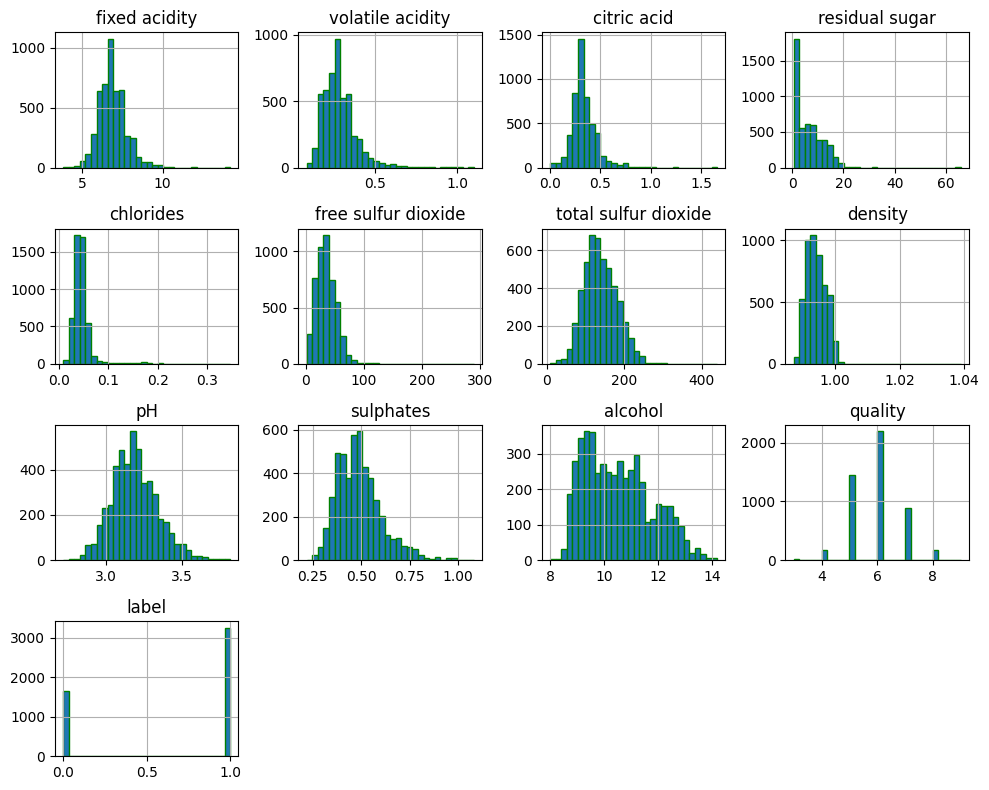

In [20]:
htg = graf.hist(
    figsize=(10, 8),
    bins=30,
    edgecolor='green')
plt.tight_layout()
plt.show()

Boxplot

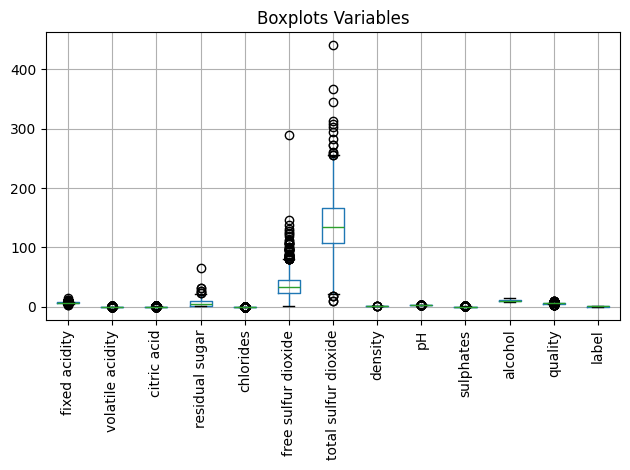

In [21]:
plt.figure()
graf.boxplot(rot=90)
plt.title("Boxplots Variables")
plt.tight_layout()
plt.show()

Correlacion de variables numericas

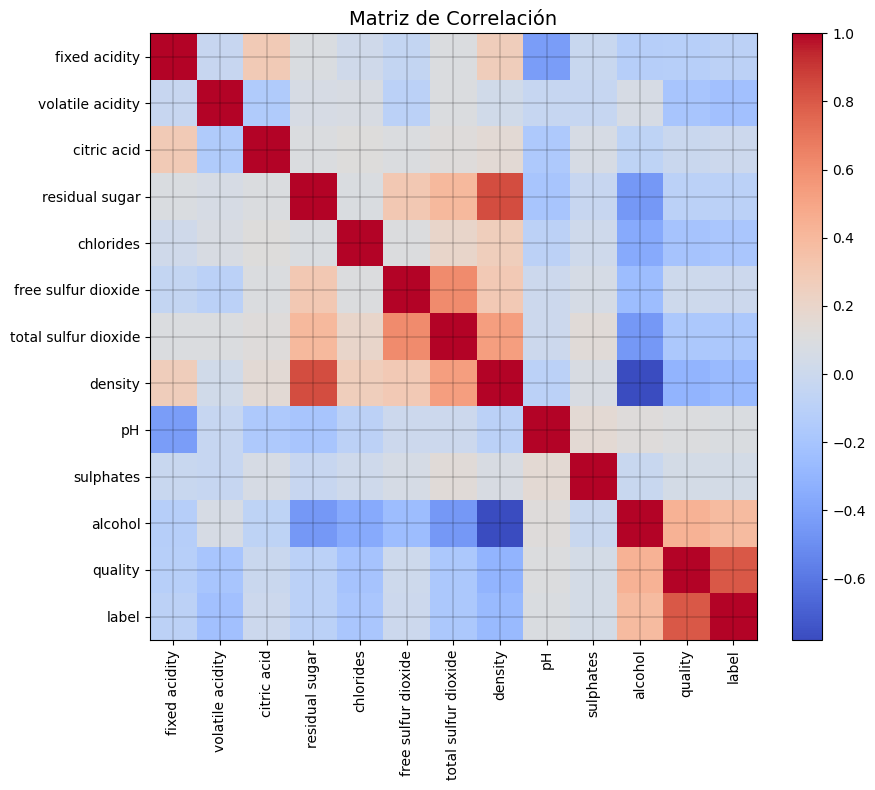

In [24]:
plt.figure(figsize=(10, 8))
corr = graf.corr(numeric_only=True)
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.grid(which='major', color='black', linestyle='-', linewidth=0.2)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Matriz de Correlación", fontsize=14)
plt.tight_layout()
plt.show()


6. Preparacion de datos 

*Combinamos columnas numericas en un vector, normalizamos-estandarizamos los valores del vector para tener la misma escala para despues encadenar transformaciones en una sola estructura ordenada.*

In [26]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

feature_cols = [c for c in white.columns if c not in ['quality', 'label']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features")

pipeline_prep = Pipeline(stages=[assembler, scaler])
prepared = pipeline_prep.fit(white).transform(white)

train, test = prepared.randomSplit([0.8, 0.2], seed=42)
train.count(), test.count()

(3961, 937)

7. Generando un modelo de regresion logistica.

*Generamos el modelo de regresion logistica*


In [28]:

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train)
pred_lr = lr_model.transform(test)
pred_lr.select("label", "prediction", "probability").show(5, truncate=False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|1    |1.0       |[0.008758097282280468,0.9912419027177195]|
|1    |1.0       |[0.1972031903959089,0.8027968096040912]  |
|0    |0.0       |[0.7727994944069964,0.22720050559300364] |
|1    |1.0       |[0.18696406796858547,0.8130359320314146] |
|1    |1.0       |[0.12535176447664373,0.8746482355233562] |
+-----+----------+-----------------------------------------+
only showing top 5 rows



**Observamos que contamos con predicciones correctas en la muestra y que contamos con alta probabilidad para predicciones acertadas pero no se pierde la probabilidad que el modelo no sea seguro y nos indique separacion entre clases y que no sea clara**

*Evaluamos el modelo con AUC-ROC (LR)* 

In [37]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction')
auc_lr = evaluator.evaluate(pred_lr)
print("AUC LR:", auc_lr)


AUC LR: 0.7970445808996074


*Evaluamos precision del modelo (RL)*

In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(pred_lr)
print(f"Exactitud del modelo: {accuracy:.2f}")

Exactitud del modelo: 0.74


**Observamos que la regresión logística tiene un desempeño razonablemente bueno y que tenemos un 79% de probabilidad de que este modelo asigne una evento positivo, con respecto a la exactitud consideramos que tambien puede considerarse bueno**

*Generaremos la grafica ROC y PR para visualizar mejor el modelo* 

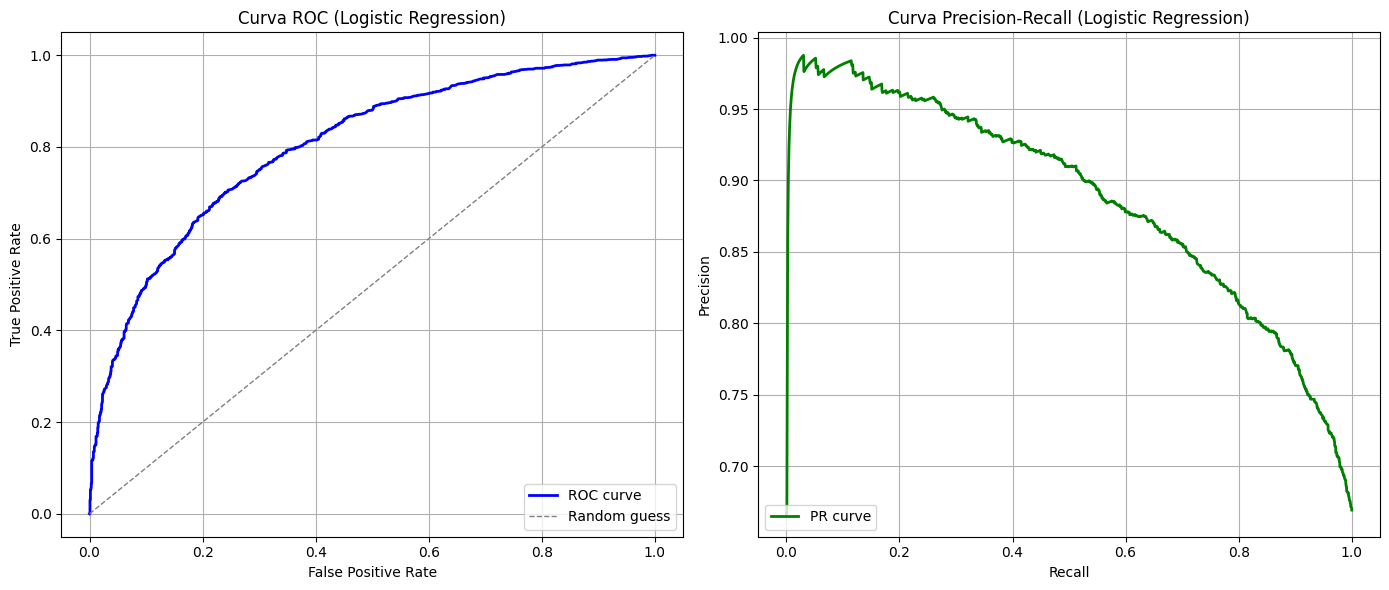

In [31]:
import matplotlib.pyplot as plt

train_summary = lr_model.summary
roc_df = train_summary.roc.toPandas()
pr_df = train_summary.pr.toPandas()
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# === Curva ROC ===
axes[0].plot(roc_df['FPR'], roc_df['TPR'], color='blue', lw=2, label='ROC curve')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random guess')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Curva ROC (Logistic Regression)')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# === Curva Precision-Recall ===
axes[1].plot(pr_df['recall'], pr_df['precision'], color='green', lw=2, label='PR curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Curva Precision-Recall (Logistic Regression)')
axes[1].legend(loc='lower left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Conclusiones
Podemos observar en la curva de manera general que la curva ROC indica que el modelo distingue razonablemente bien entre clases, obteniendo un AUC 0.79 tiene buena capacidad discriminativa, es buena aproximacion a comparacion de un modelo aleatorio, es probable que podriamos obtener poco falsos positivos pero aun no libramos de esa posibilidad. Se puede concluir tambien que el modelo cada que predice positivo tiene por lo general una buena acertividad, algo que destacar es que el recall cuando aumenta la precision baja por lo cual podemos llegar a encontrarnos con falsos positivos, esto va acorde ya que el dataset se puede inferir que es desbalanceado. Por lo cual el modelo funciona y es preciso. 
